In [90]:
import pandas as pd
import numpy as np
import os
import sys
from datetime import datetime
# Make `src` dir can be imported
project_root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))  # /aicup-predict-energy-generation
sys.path.append(project_root_path)

from src.utils import choose_device


import matplotlib.pyplot as plt
import seaborn as sns

from src.fe_tools import create_time_features

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [108]:
def plot_daily_feature(df: pd.DataFrame, column: str, agg_method: str = 'mean'):
    # Convert 'datetime' column to datetime type if it's not already
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # Check if the aggregation method is valid
    if agg_method not in ['sum', 'mean', 'min', 'max', 'median']:
        raise ValueError("Invalid aggregation method. Choose from 'sum', 'mean', 'min', 'max', 'median'.")
    
    # Group by date and calculate the aggregation for each day
    df_daily = df.groupby(df['datetime'].dt.date)[column].agg(agg_method)
    
    # Plotting the selected feature over date
    plt.figure(figsize=(12, 3))
    plt.plot(df_daily.index, df_daily.values, marker='o', color='orange', label=column.capitalize())
    plt.xlabel('Date')
    plt.ylabel(column.capitalize())
    plt.title(f'Daily {agg_method.capitalize()} of {column.capitalize()}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


def optimal_k_elbow(X, max_k=10):
    # Define the range of clusters to try
    k_values = range(1, max_k + 1)
    inertias = []

    # Calculate inertia for each k value
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)

    # Calculate the differences between consecutive inertia values
    inertia_diff = np.diff(inertias)
    # Calculate the second derivative (rate of change of inertia reduction)
    inertia_diff2 = np.diff(inertia_diff)

    # Find the index of the maximum change in the second derivative
    elbow_point = np.argmin(inertia_diff2) + 1  # Adding 1 to match cluster count (since diff reduces array size by 1)

    # Plotting the elbow curve
    plt.figure(figsize=(8, 4))
    plt.plot(k_values, inertias, marker='o')
    plt.axvline(x=elbow_point + 1, color='red', linestyle='--', label=f'Optimal k={elbow_point + 1}')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.legend()
    plt.show()

    return elbow_point + 1  # Adjusting for index starting at 0



In [4]:
df_raw_data = pd.read_csv('../data/processed_data/combined_data.csv')
df_raw_data['datetime'] = pd.to_datetime(df_raw_data['datetime'])
# make sure the sorting is correct
df_raw_data = df_raw_data.sort_values(by=['device','datetime']).reset_index(drop=True)

df_device = choose_device(df_raw_data, 'L10')

In [11]:
sl_max = 117758.2

In [122]:
df_sl = df_device[['datetime', 'sunlight', 'power', 'humidity']]

In [123]:
df_sl.max()

datetime    2024-07-22 05:19:28
sunlight               117758.2
power                    2393.1
humidity                  100.0
dtype: object

In [124]:
df_sl.loc[:, 'max_check'] = df_sl.apply(lambda x: 1 if x['sunlight'] >= sl_max else 0, axis=1)

C:\Users\sean.chang\AppData\Local\Temp\ipykernel_37068\4246696044.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sl.loc[:, 'max_check'] = df_sl.apply(lambda x: 1 if x['sunlight'] >= sl_max else 0, axis=1)


In [125]:
df_sl.max_check.value_counts()

max_check
0    90077
1     1263
Name: count, dtype: int64

In [126]:
df_sl[df_sl['max_check'] == 1]

,datetime,sunlight,power,humidity,max_check
102788,2024-03-03 11:50:47,117758.2,2337.67,38.14,1
102882,2024-03-03 13:24:47,117758.2,2393.10,46.77,1
102885,2024-03-03 13:27:47,117758.2,2023.63,38.25,1
103575,2024-03-04 12:44:47,117758.2,1857.72,24.18,1
103576,2024-03-04 12:45:47,117758.2,1849.07,23.14,1
...,...,...,...,...,...
192614,2024-07-21 12:24:27,117758.2,1694.13,24.70,1
192615,2024-07-21 12:25:27,117758.2,1703.16,24.69,1
192616,2024-07-21 12:26:27,117758.2,1687.39,24.96,1
192617,2024-07-21 12:27:27,117758.2,1693.83,24.64,1


In [127]:
def filter_by_date_with_features(df, month, day):
    # Filter the DataFrame by date starting from the specified month and day
    filtered_df = df[df['datetime'].dt.date >= datetime(2024, month, day).date()]
    
    # Add time-based features
    filtered_df = create_time_features(filtered_df, 'datetime')

    return filtered_df

# Example usage
df_date_filter = filter_by_date_with_features(df_sl, month=1, day=1)


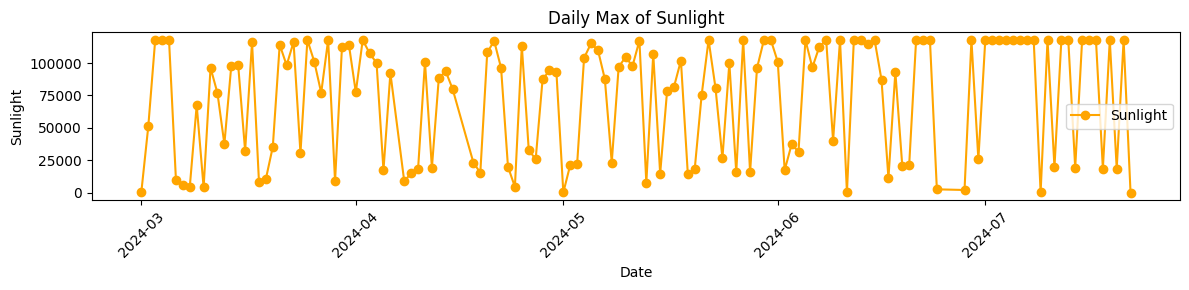

In [128]:
# Example usage
plot_daily_feature(df_date_filter, column='sunlight', agg_method='max')

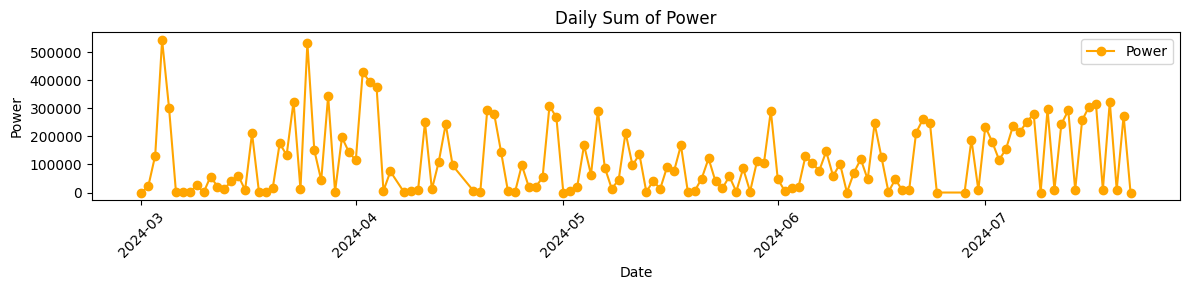

In [129]:
plot_daily_feature(df_date_filter, column='power', agg_method='sum')

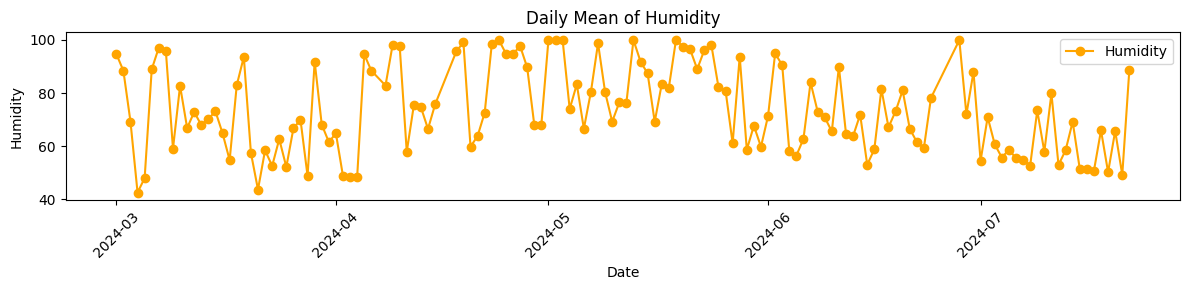

In [130]:
plot_daily_feature(df_date_filter, column='humidity', agg_method='mean')

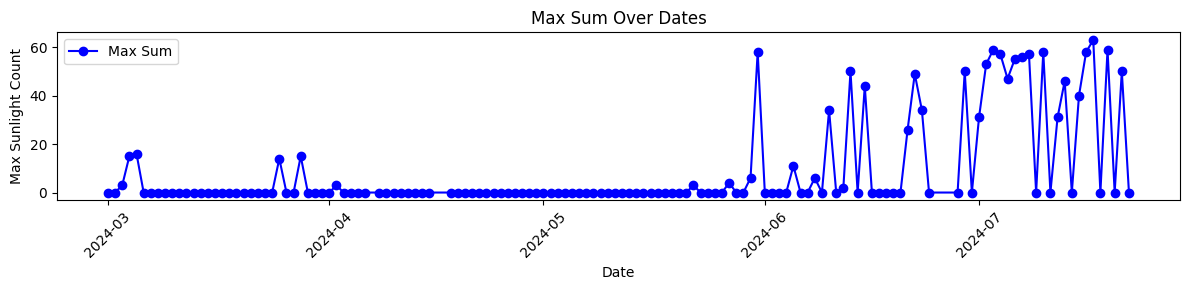

In [117]:
df_max_sunlight_count = df_date_filter.groupby(['date']).agg(max_count=('max_check', 'sum')).reset_index()

df_max_sunlight_count['date'] = pd.to_datetime(df_max_sunlight_count['date'])

# Plotting the max_sum over dates
plt.figure(figsize=(12, 3))
plt.plot(df_max_sunlight_count['date'], df_max_sunlight_count['max_count'], marker='o', color='b', label='Max Sum')
plt.xlabel('Date')
plt.ylabel('Max Sunlight Count')
plt.title('Max Sum Over Dates')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

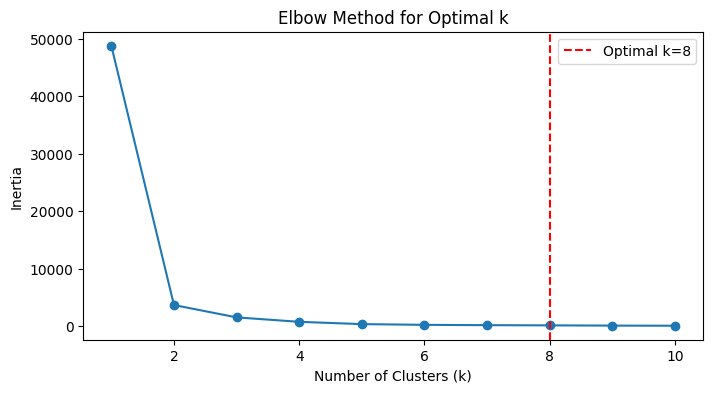

The optimal number of clusters according to the Elbow Method is: 8


In [118]:
df = df_max_sunlight_count

X = df[['max_count']]
# Usage
best_k = optimal_k_elbow(X, max_k=10)
print(f"The optimal number of clusters according to the Elbow Method is: {best_k}")

- However, maybe we choose 2 at first

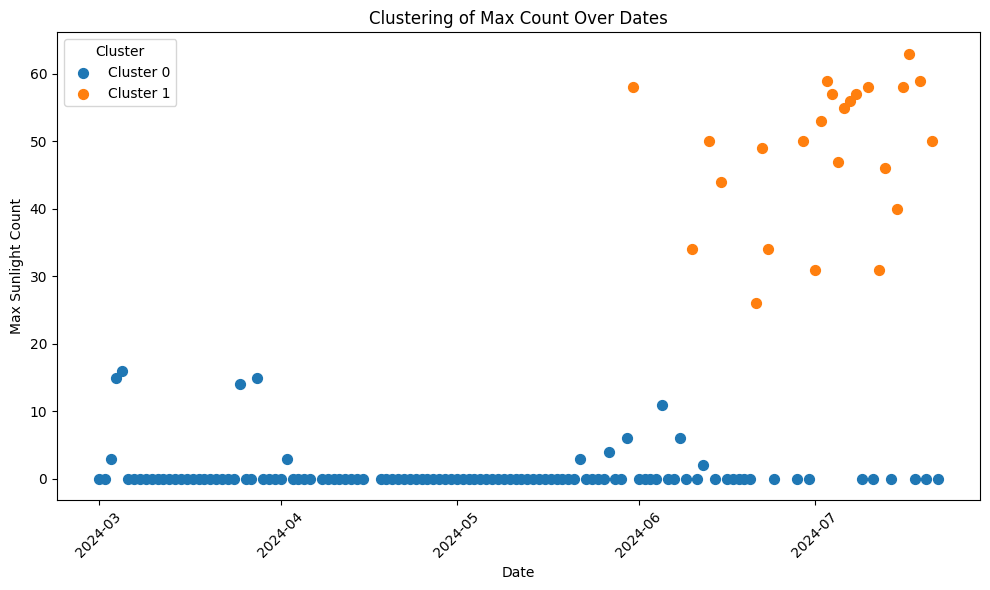

In [120]:
best_k = 2

# Perform KMeans clustering
kmeans = KMeans(n_clusters=best_k, random_state=0)
df['cluster'] = kmeans.fit_predict(X)

# Plotting the clustering results
plt.figure(figsize=(10, 6))

# Create a scatter plot for each cluster
for cluster in range(best_k):
    clustered_data = df[df['cluster'] == cluster]
    plt.scatter(clustered_data['date'], clustered_data['max_count'], label=f'Cluster {cluster}', s=50)

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Max Sunlight Count')
plt.title('Clustering of Max Count Over Dates')
plt.legend(title="Cluster")
plt.xticks(rotation=45)
plt.tight_layout()